In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import string
from matplotlib_venn import venn2

from utils import DEFAULT_PALETTE_RAINBOW

tqdm.pandas()

In [2]:
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

In [3]:
sns.set_style(style="ticks")
sns.set_context(context="talk")

### Load dataset

In [4]:
df = pd.read_csv(
    f"{DATA_DIR}/processed/enpkg_data_with_threshold.tsv",
    sep="\t",
)
df.head(2)

,inchikey,smiles,np_class,np_superclass,np_pathway,massive_id,confidence_score,wikidata_species_id,type_by_confidence (t=0.5)
0,KAHZQJKLALFAGB,CC(CCC(=O)O)C1CCC2C1(CCC3C2C(C(C4C3(CC(C(C4)O)...,Cholane steroids,Steroids,Terpenoids,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,0.096916,Q715019,unknown
1,LSUXCWJOIAWGOU,CCCCCC=CCC=CCCCCCCCC(=O)OC(CO)COP(=O)(O)OCC[N+...,unknown,unknown,unknown,lcms_feature_mzspec:MSV000093464:KP072_Positiv...,0.227740,Q715019,unknown


### Subset data into known and unknown classes

In [5]:
known_df = df[df["type_by_confidence (t=0.5)"] == "known"]
unknown_df = df[df["type_by_confidence (t=0.5)"] == "unknown"]

len(known_df), len(unknown_df)

(190289, 816508)

In [6]:
known_classes = set(known_df["np_class"].unique())
known_superclasses = set(known_df["np_superclass"].unique())
known_pathways = set(known_df["np_pathway"].unique())

len(known_classes), len(known_superclasses), len(known_pathways)

(475, 75, 8)

In [7]:
unknown_classes = set(unknown_df["np_class"].unique())
unknown_superclasses = set(unknown_df["np_superclass"].unique())
unknown_pathways = set(unknown_df["np_pathway"].unique())

len(unknown_classes), len(unknown_superclasses), len(unknown_pathways)

(585, 75, 8)

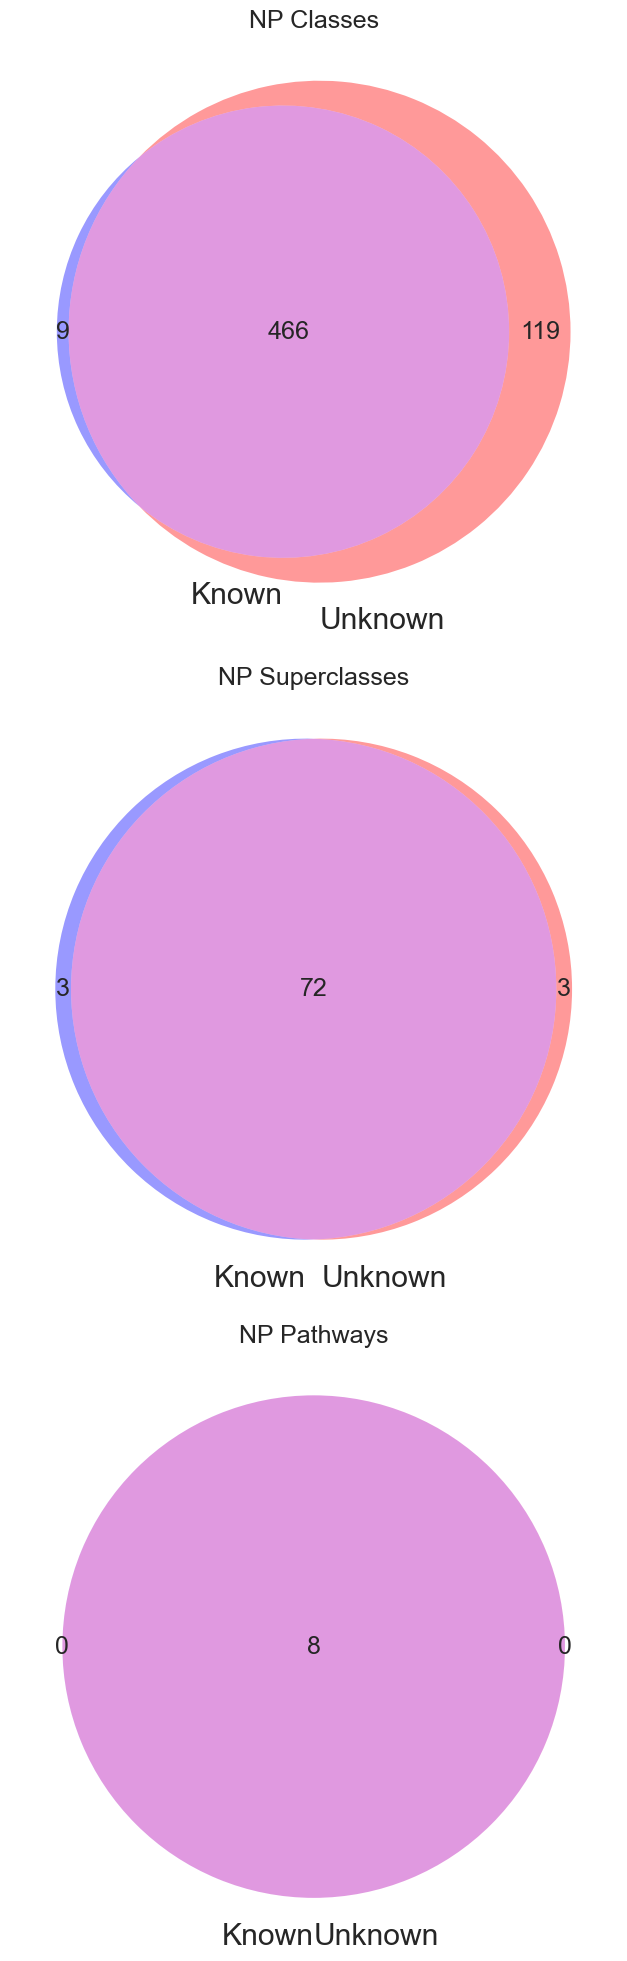

In [8]:
plt.figure(figsize=(10, 20))

plt.subplot(3, 1, 1)
venn2(
    [known_classes, unknown_classes],
    set_labels=("Known", "Unknown"),
    set_colors=("blue", "red"),
)
plt.title("NP Classes")

plt.subplot(3, 1, 2)
venn2(
    [known_superclasses, unknown_superclasses],
    set_labels=("Known", "Unknown"),
    set_colors=("blue", "red"),
)
plt.title("NP Superclasses")

plt.subplot(3, 1, 3)
venn2(
    [known_pathways, unknown_pathways],
    set_labels=("Known", "Unknown"),
    set_colors=("blue", "red"),
)
plt.title("NP Pathways")

plt.tight_layout()
plt.show()

### Looking at unknown only space

In [9]:
only_unknown_classes = unknown_classes - known_classes
only_unknown_superclasses = unknown_superclasses - known_superclasses

In [10]:
only_unknown_classes_df = unknown_df[unknown_df["np_class"].isin(only_unknown_classes)]
only_unknown_superclasses_df = unknown_df[
    unknown_df["np_superclass"].isin(only_unknown_superclasses)
]

In [11]:
only_unknown_classes_df = only_unknown_classes_df[
    ["inchikey", "np_class"]
].drop_duplicates()
only_unknown_superclasses_df = only_unknown_superclasses_df[
    ["inchikey", "np_superclass"]
].drop_duplicates()

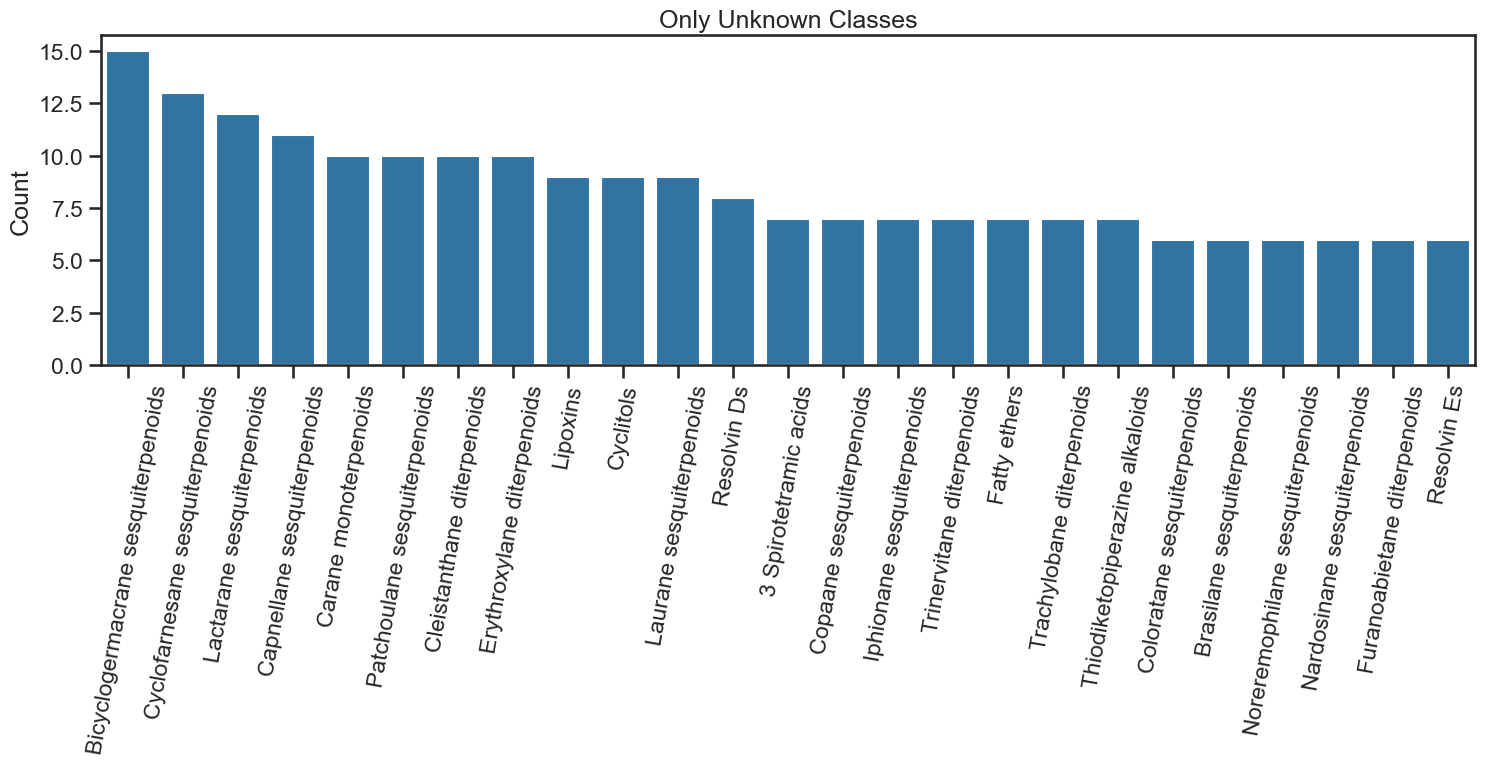

In [12]:
kk = only_unknown_classes_df["np_class"].value_counts().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=kk[kk["count"] > 5], x="np_class", y="count")
plt.xticks(rotation=80)
plt.title("Only Unknown Classes")
plt.xlabel("")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

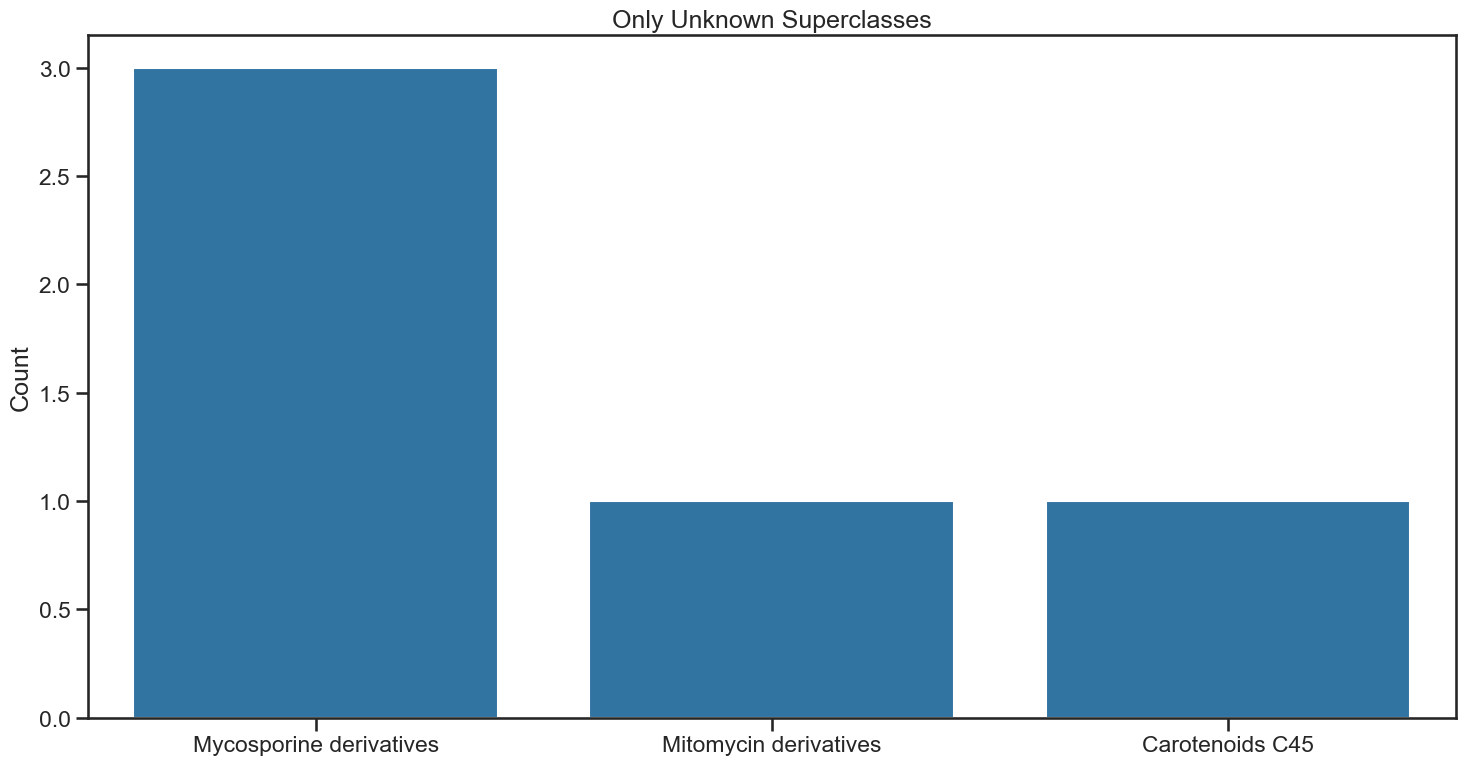

In [13]:
kk2 = only_unknown_superclasses_df["np_superclass"].value_counts().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=kk2, x="np_superclass", y="count")
plt.title("Only Unknown Superclasses")
plt.xlabel("")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Looking at the overlapped space

In [14]:
overlap_classes = known_classes & unknown_classes
overlap_superclasses = known_superclasses & unknown_superclasses

In [15]:
def get_pie_plot(
    title: str,
    col_name: str,
    known_df: pd.DataFrame,
    unknown_df: pd.DataFrame,
    overlap_set: set,
):
    tmp_known_df = known_df[known_df[col_name].isin(overlap_set)]
    tmp_unknown_df = unknown_df[unknown_df[col_name].isin(overlap_set)]

    tmp_known_df = tmp_known_df[["inchikey", col_name]].drop_duplicates()
    tmp_unknown_df = tmp_unknown_df[["inchikey", col_name]].drop_duplicates()

    mm_1 = tmp_known_df[col_name].value_counts().reset_index().head(10)
    mm_2 = tmp_unknown_df[col_name].value_counts().reset_index().head(10)

    plt.figure(figsize=(17, 12))

    # pie chart font size smaller
    plt.rcParams.update({"font.size": 10})

    plt.subplot(2, 2, 1)
    plt.pie(
        mm_1["count"],
        labels=mm_1[col_name],
        autopct="%1.1f%%",
        colors=DEFAULT_PALETTE_RAINBOW,
    )
    plt.title(f"Known {title}")

    plt.text(
        -0.1,
        1.1,
        string.ascii_uppercase[0],
        size=25,
        weight="bold",
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
    )

    plt.subplot(2, 2, 2)
    plt.pie(
        mm_2["count"],
        labels=mm_2[col_name],
        autopct="%1.1f%%",
        colors=DEFAULT_PALETTE_RAINBOW,
    )
    plt.title(f"Unknown {title}")

    plt.text(
        -0.1,
        1.1,
        string.ascii_uppercase[1],
        size=25,
        weight="bold",
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
    )

    tmp_known_classes_common_df = tmp_known_df[tmp_known_df[col_name] != "unknown"]
    tmp_unknown_classes_common_df = tmp_unknown_df[
        tmp_unknown_df[col_name] != "unknown"
    ]

    mm_1 = tmp_known_classes_common_df[col_name].value_counts().reset_index().head(10)
    mm_2 = tmp_unknown_classes_common_df[col_name].value_counts().reset_index().head(10)

    plt.subplot(2, 2, 3)
    plt.pie(
        mm_1["count"],
        labels=mm_1[col_name],
        autopct="%1.1f%%",
        colors=DEFAULT_PALETTE_RAINBOW,
    )
    plt.title(f"Known {title} (Excluding Unknown)")
    plt.text(
        -0.1,
        1.1,
        string.ascii_uppercase[2],
        size=25,
        weight="bold",
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
    )

    plt.subplot(2, 2, 4)
    plt.pie(
        mm_2["count"],
        labels=mm_2[col_name],
        autopct="%1.1f%%",
        colors=DEFAULT_PALETTE_RAINBOW,
    )
    plt.title(f"Unknown {title} (Excluding Unknown)")
    plt.text(
        -0.1,
        1.1,
        string.ascii_uppercase[3],
        size=25,
        weight="bold",
        horizontalalignment="center",
        verticalalignment="center",
        transform=plt.gca().transAxes,
    )

    plt.tight_layout()
    plt.show()

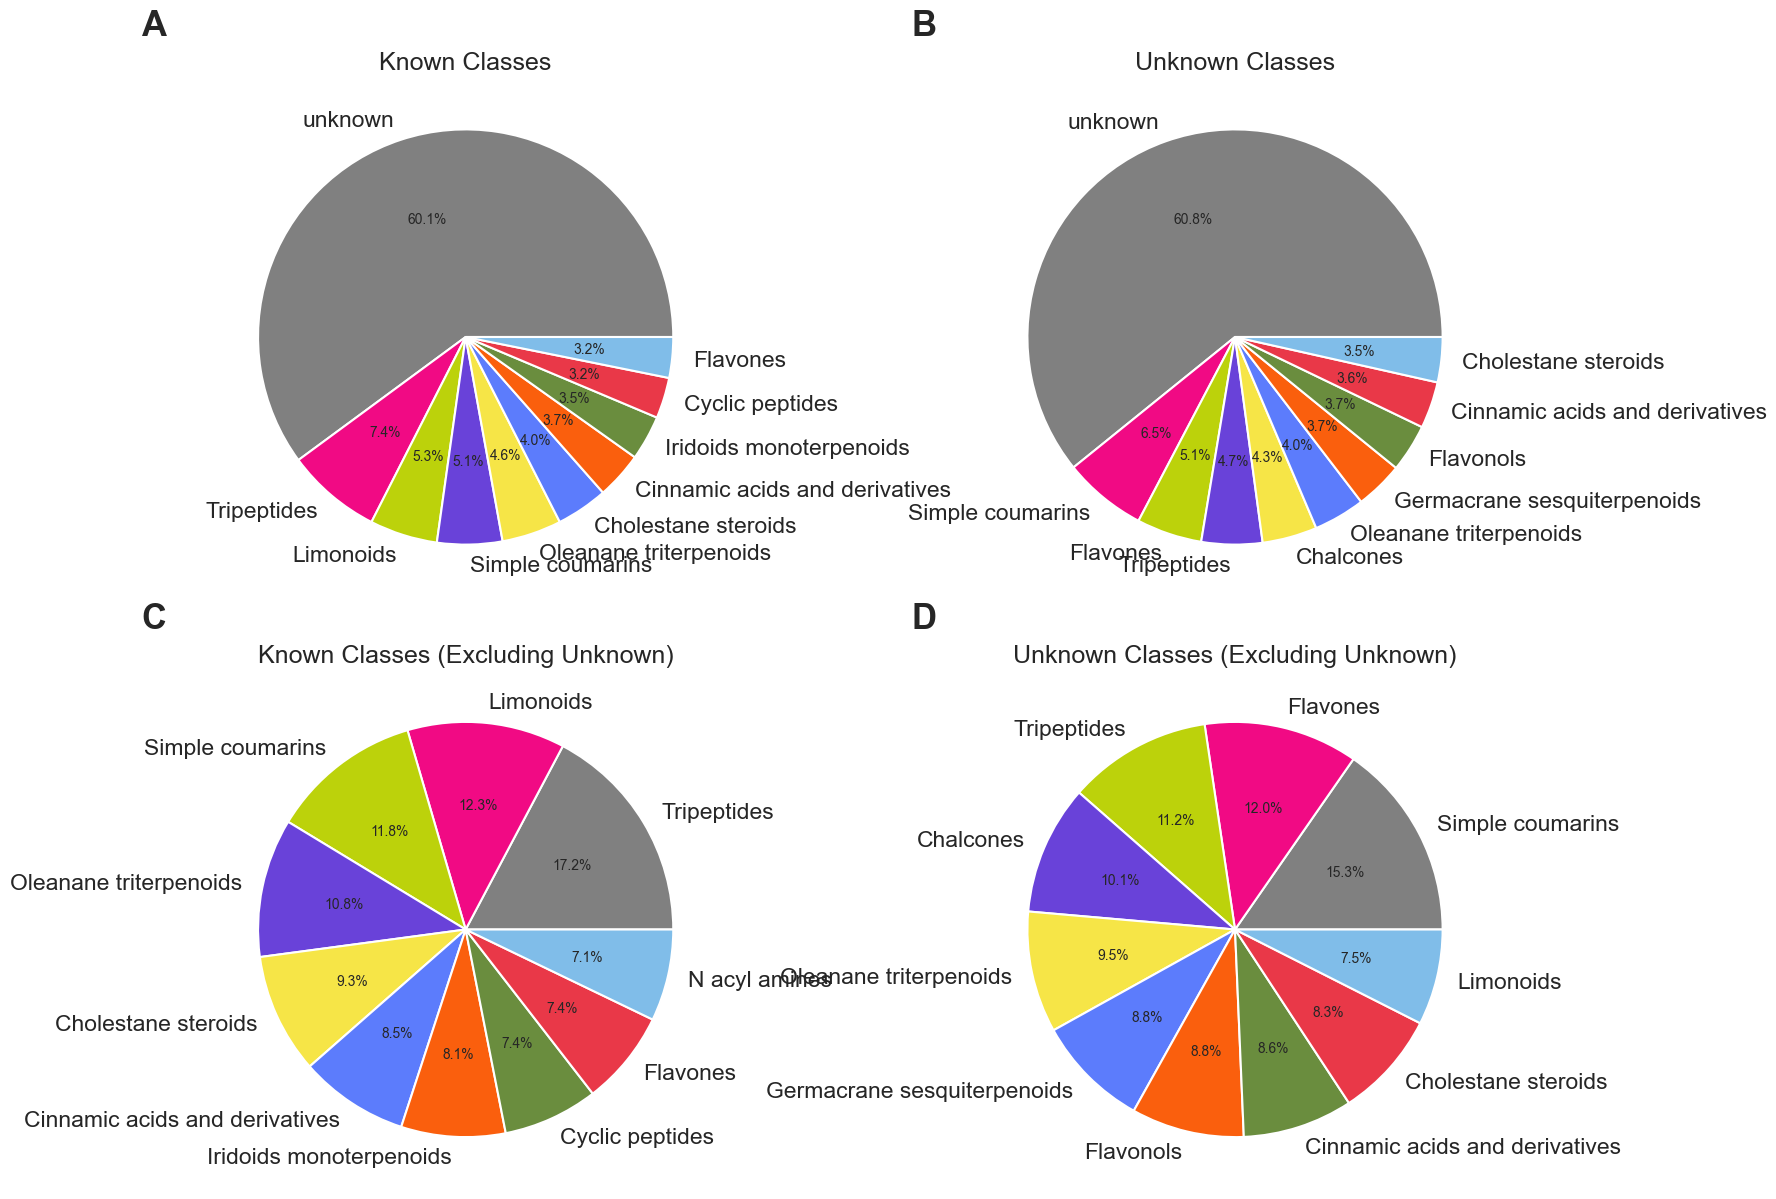

In [16]:
get_pie_plot("Classes", "np_class", known_df, unknown_df, overlap_classes)

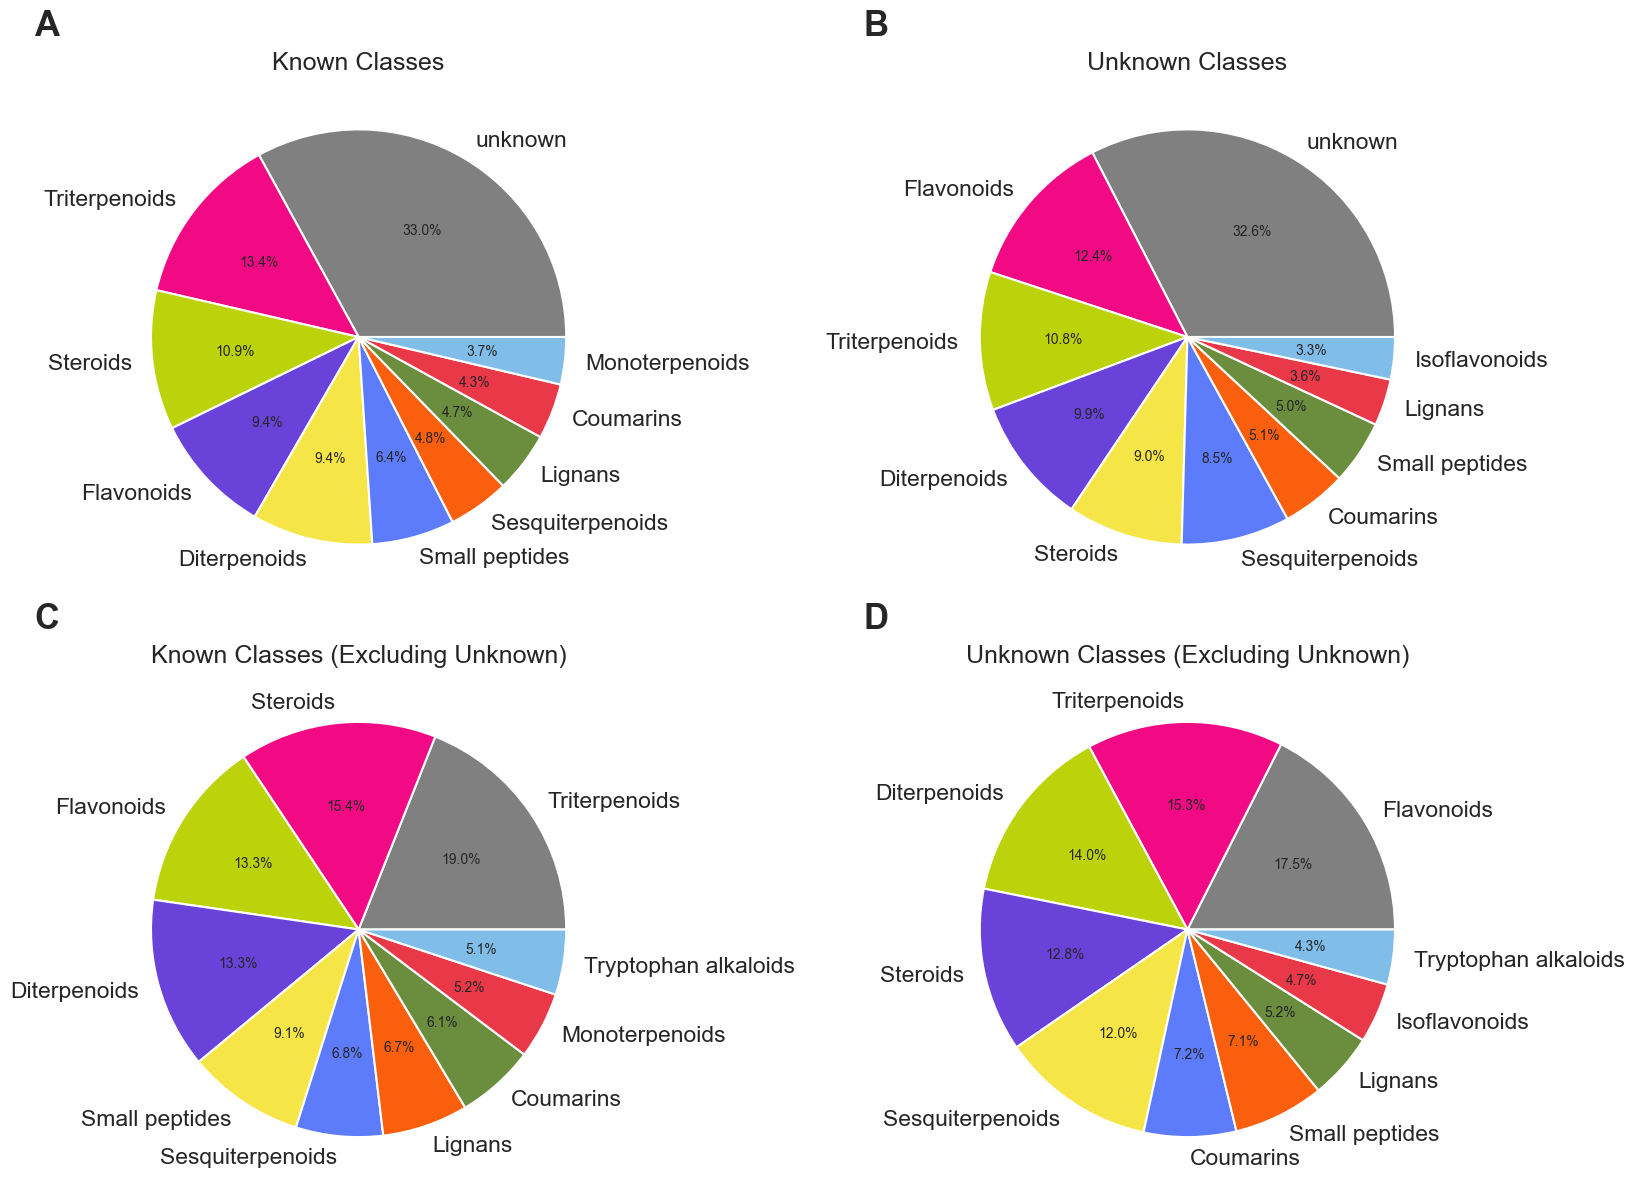

In [17]:
get_pie_plot("Classes", "np_superclass", known_df, unknown_df, overlap_superclasses)